# todo:

- 设计一个BA的循环算法，现在的问题是每次循环之后boundary nodes没有更新，而det的class已经变成了class2，所以判定为需要ba的det一直在进行修改class这个操作（虽然他们已经修改过）。所以需要做的是在修改后进行一次boundary node的更新。思路是重新判定一次boundary nodes和boundary dets。

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm
import networkx.algorithms.community as nxcom
from community import community_louvain
import ipdb

In [2]:
def get_corr(data):
    data = np.array(q)
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data = (data-data_mean) / data_std
    data_c = np.corrcoef(data)
    return data_c

In [3]:
randseed = 25
seg = pd.read_csv('../data/segement.csv', header=None)
raw0 = pd.read_csv(open('../data/id2000.csv'), header=0, index_col=0)
q = pd.read_csv('../data/q_20_aggragated.csv', index_col = 0)
b = pd.read_csv('../data/b_20_aggragated.csv', index_col = 0)  # time occupancy, (density)

raw0

,id2,lat,long,id,num_road,class
0,2001,116.42769,39.94485,HI7000d,4,0
1,2002,116.42764,39.94330,HI7001a,3,0
2,2003,116.42782,39.93705,HI7002a,2,0
3,2005,116.42832,39.92993,HI7039a,3,0
4,2006,116.42785,39.92513,HI7003a,3,0
...,...,...,...,...,...,...
202,61004,116.29400,39.97990,HI9037g,3,3
203,61005,116.29300,39.98990,HI9097c,3,3
204,61006,116.29000,39.99350,HI9098c,3,3
205,61007,116.28600,39.99870,HI9099c,3,3


In [4]:
q_det = q.T.mean()
b_det = b.T.mean()

In [5]:
nodes = np.array(raw0['id2'])

relation_df = pd.read_csv('../data/edges_all.csv', header = None)

In [6]:
seg

,0,1,2,3,4,5,6,7
0,2001,东直门桥北728米（内环）,116.42769,39.94485,4,3,HI7000d,HI7060b
1,2002,东直门桥北539米人行天桥西（外环）,116.42764,39.94330,3,3,HI7001a,HI7000c
2,2003,东直门南机非隔离带内现况视频旁（外环）,116.42782,39.93705,2,3,HI7002a,HI7001c
3,2004,东四十条桥北绿地内中航大厦南20米,116.42760,39.93413,3,3,NaN,NaN
4,2005,东四十条桥南富华大厦附近（外环）,116.42832,39.92993,3,3,HI7039a,HI7002c
...,...,...,...,...,...,...,...,...
227,61005,万泉河桥北第一天桥北,116.29300,39.98990,3,3,HI9097c,HI9037a
228,61006,万泉河桥北第二天桥北,116.29000,39.99350,3,3,HI9098c,HI9097a
229,61007,万泉河桥北无名北立交桥,116.28600,39.99870,3,3,HI9099c,HI9098a
230,61008,无名北立交桥桥北,116.28200,40.00340,3,3,HI9100c,HI9099a


In [7]:
def assemble_det_relation_df(relation_df, seg, raw0, side):
    # side should be 0 or 1
    if side==1:
        side_ind = 6
    elif side==2:
        side_ind = 7
    det_relation_df = pd.DataFrame(columns=['from_det', 'to_det', 'flow', 'linkID'], index=range(len(relation_df)))
    for i in range(len(relation_df)):
        from_node = relation_df.iloc[i, 0]
        to_node = relation_df.iloc[i, 1]
        from_det = seg.loc[seg[0]==from_node].iloc[0, side_ind]  # 0 indicates node
        to_det = seg.loc[seg[0]==to_node].iloc[0, side_ind]
        det_relation_df.loc[i, 'from_det'] = from_det
        det_relation_df.loc[i, 'to_det'] = to_det
        try:
            # flow是两个detector的flow的平均
            det_relation_df.iloc[i, 2] = (q_det[from_det] + q_det[to_det]) / 2
        except:
            # 假如det没有，就用node信息找到flow
            try:
                from_node = seg[seg[6]==from_det].iloc[0, 0]
                to_node = seg[seg[6]==to_det].iloc[0, 0]
            except:
                from_node = seg[seg[7]==from_det].iloc[0, 0]
                to_node = seg[seg[7]==to_det].iloc[0, 0]
                
            from_det = raw0[raw0['id2']==from_node]['id'].iloc[0]
            to_det = raw0[raw0['id2']==to_node]['id'].iloc[0]
            
            det_relation_df.loc[i, 'flow'] = (q_det[from_det] + q_det[to_det]) / 2
        
        det_relation_df.loc[i, 'linkID'] = i
    return det_relation_df

In [8]:
# 1 and 2 are different directions
det_relation_df1 = assemble_det_relation_df(relation_df, seg, raw0, side=1)
det_relation_df2 = assemble_det_relation_df(relation_df, seg, raw0, side=2)
det_relation_df1

,from_det,to_det,flow,linkID
0,HI7000d,HI7001a,467.752532,0
1,HI7001a,HI7002a,346.657907,1
2,HI7002a,HI7039a,290.099123,2
3,HI7039a,HI7003a,394.707314,3
4,HI7003a,HI7040a,431.02215,4
...,...,...,...,...
235,HI9037g,HI9038d,398.524133,235
236,HI9097c,HI9036a,439.800678,236
237,HI9097c,HI9038d,375.03186,237
238,HI9095c,HI8034d,263.39755,238


In [9]:
relation_df['flow'] = ''
relation_df['linkID'] = ''

for i in range(len(relation_df)):
    #ipdb.set_trace()
    det1 = raw0[raw0['id2']==relation_df.iloc[i, 0]]['id'].iloc[0]
    det2 = raw0[raw0['id2']==relation_df.iloc[i, 1]]['id'].iloc[0]
    relation_df.loc[i, 'flow'] = (q_det[det1] + q_det[det2]) / 2
    relation_df.loc[i, 'linkID'] = i

relation_df

,0,1,flow,linkID
0,2001,2002,467.752532,0
1,2002,2003,346.657907,1
2,2003,2005,290.099123,2
3,2005,2006,394.707314,3
4,2006,2007,431.02215,4
...,...,...,...,...
235,61004,4045,398.524133,235
236,61005,4043,439.800678,236
237,61005,4045,375.03186,237
238,61001,3051,263.39755,238


In [10]:
relation = np.array(relation_df.iloc[:, :3])  # relation and flow (weight)

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(relation)  # add weight from flow

print('There are %d nodes.' % G.number_of_nodes())
print('There are %d edges.' % G.number_of_edges())

There are 207 nodes.
There are 240 edges.


In [11]:
pos0 = raw0.iloc[:, 1:3]
pos0 = np.array(pos0)

vnode = pos0
npos = dict(zip(nodes, vnode))  # 获取节点与坐标之间的映射关系，用字典表示

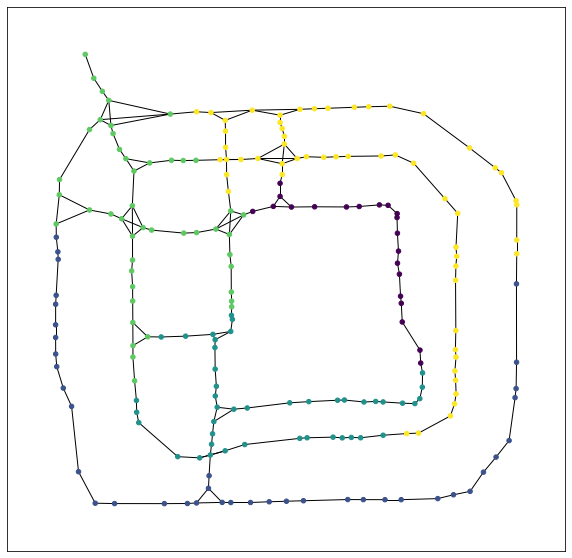

In [12]:
partition = community_louvain.best_partition(G, resolution=11, weight='weight', random_state=randseed)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition.values()), with_labels=False)
#plt.savefig('./res/img/%i_net'%randseed)

In [13]:
partition_results = pd.DataFrame(data = list(partition.values()))

partition_results['node'] = nodes

In [14]:
def get_det_partition_results(seg, partition_results, side):
    if side==1:
        side_ind = 6
    elif side==2:
        side_ind = 7
    
    det_partition_results = pd.DataFrame([], columns=[0, 'det'], index=range(len(partition_results)))
    for i in range(len(partition_results)):
        det_partition_results.loc[i, 'det'] = seg[seg[0]==partition_results.loc[i, 'node']].iloc[0, side_ind]
    
    det_partition_results.loc[:, 0] = partition_results.loc[:, 0]
    return det_partition_results

In [15]:
det_partition_results1 = get_det_partition_results(seg, partition_results, side=1)
det_partition_results2 = get_det_partition_results(seg, partition_results, side=2)
det_partition_results1

,0,det
0,0,HI7000d
1,0,HI7001a
2,0,HI7002a
3,0,HI7039a
4,0,HI7003a
...,...,...
202,3,HI9037g
203,3,HI9097c
204,3,HI9098c
205,3,HI9099c


In [16]:
partition_results

,0,node
0,0,2001
1,0,2002
2,0,2003
3,0,2005
4,0,2006
...,...,...
202,3,61004
203,3,61005
204,3,61006
205,3,61007


In [17]:
partition_results.to_csv('../res/%i_partition_results.csv'%randseed, index=False)
det_partition_results1.to_csv('../res/%i_det_partition_results1.csv'%randseed, index=False)
det_partition_results2.to_csv('../res/%i_det_partition_results2.csv'%randseed, index=False)

# 接下来制作边缘node的df

In [18]:
relation_df

,0,1,flow,linkID
0,2001,2002,467.752532,0
1,2002,2003,346.657907,1
2,2003,2005,290.099123,2
3,2005,2006,394.707314,3
4,2006,2007,431.02215,4
...,...,...,...,...
235,61004,4045,398.524133,235
236,61005,4043,439.800678,236
237,61005,4045,375.03186,237
238,61001,3051,263.39755,238


In [19]:
det_relation_df1

,from_det,to_det,flow,linkID
0,HI7000d,HI7001a,467.752532,0
1,HI7001a,HI7002a,346.657907,1
2,HI7002a,HI7039a,290.099123,2
3,HI7039a,HI7003a,394.707314,3
4,HI7003a,HI7040a,431.02215,4
...,...,...,...,...
235,HI9037g,HI9038d,398.524133,235
236,HI9097c,HI9036a,439.800678,236
237,HI9097c,HI9038d,375.03186,237
238,HI9095c,HI8034d,263.39755,238


In [20]:
b_det = pd.DataFrame(b_det)
b_det['det'] = b_det.index
b_det['node']=''
b_det.index=range(402)

for i in range(len(b_det)):
    try:
        b_det.iloc[i, 2] = seg[seg[6]==b_det.iloc[i, 1]].iloc[0, 0]
    except:
        b_det.iloc[i, 2] = seg[seg[7]==b_det.iloc[i, 1]].iloc[0, 0]

b_det['class'] = ''
for i in range(len(b_det)):
    b_det.iloc[i, 3] = partition_results[partition_results['node']==b_det.iloc[i, 2]].iloc[0, 0]


In [21]:
b_det  # column 0 means occupance

,0,det,node,class
0,13.016764,HI2063a,3044,3
1,19.076875,HI2063c,3043,3
2,4.800302,HI2065a,3046,3
3,13.778998,HI2065c,3044,3
4,5.571532,HI2068a,2043,2
...,...,...,...,...
397,7.279762,HI9099c,61007,3
398,10.456748,HI9100a,61009,3
399,10.709316,HI9101c,61009,3
400,7.264045,HI9102a,61004,3


In [22]:
def get_bound_x_df(relation_df, partition_results):
    relation_df['if boundary'] = ''

    for i in range(len(relation_df)):
        class1 = partition_results[partition_results.iloc[:, 1]==relation_df.iloc[i, 0]].iloc[0, 0]
        class2 = partition_results[partition_results.iloc[:, 1]==relation_df.iloc[i, 1]].iloc[0, 0]
        if class1 != class2:
            relation_df.loc[i, 'if boundary'] = 1
        else:
            relation_df.loc[i, 'if boundary'] = 0

    bound_x_df = relation_df[relation_df['if boundary']==1].iloc[:, 0:2]
    # bound_nodes = np.array(bound_x_df).flatten()
    return bound_x_df

In [23]:
def compare(det_id, b1, b2, det_partition_results):
    if_adjust = 0
    
    ini_var1 = np.var(np.array(b1[0]))  # initial variance
    ini_var2 = np.var(np.array(b2[0]))
    ini_mean1 = np.mean(np.array(b1[0]))  # initial mean
    ini_mean2 = np.mean(np.array(b2[0]))
    
    
    # 把det1从class1里面挑出来
    b1_ = b1[b1['det']!=det_id][0]
    # 计算不含det1的b11_的variance
    var1 = np.var(np.array(b1_))
    # 把det1加到class2
    b2_ = np.append(np.array(b2[0]), np.array(b1[b1['det']==det_id][0]))
    # 计算class2的variance
    var2 = np.var(b2_)
    # 比较两个variance，假如variance减小，则保留更改，反之恢复原位
    if var1<ini_var1 and var2<ini_var2:
        #ipdb.set_trace()
        class2 = b2.iloc[0, 3]  # 3 stands for class
        b_det.loc[b_det['det']==det_id, 'class'] = class2
        det_partition_results.loc[det_partition_results['det']==det_id, 0] = class2
        if_adjust = 1
    
    return b_det, det_partition_results, if_adjust

In [24]:
org_bound_dets_df1 = get_bound_x_df(det_relation_df1, det_partition_results1)
org_bound_dets_df2 = get_bound_x_df(det_relation_df2, det_partition_results2)
org_det_partition_results1 = det_partition_results1.copy()
org_det_partition_results2 = det_partition_results2.copy()

In [25]:
for i in range(len(org_bound_dets_df1)):
    adj_time = 0
    while 1:
        bound_nodes_df = get_bound_x_df(relation_df, partition_results)
        bound_dets_df1 = get_bound_x_df(det_relation_df1, det_partition_results1)
        bound_dets_df2 = get_bound_x_df(det_relation_df2, det_partition_results2)

        n1d1 = bound_dets_df1.iloc[i, 0]
        n1d2 = bound_dets_df2.iloc[i, 0]
        n2d1 = bound_dets_df1.iloc[i, 1]
        n2d2 = bound_dets_df2.iloc[i, 1]
        
        node1 = b_det[b_det['det']==n1d1].iloc[0, 2]  # 2 means node
        node2 = b_det[b_det['det']==n2d1].iloc[0, 2]

        class1 = b_det[b_det['det']==n1d1].iloc[0, 3]  # 3 means class
        class2 = b_det[b_det['det']==n2d1].iloc[0, 3]

        b1 = b_det[b_det['class']==class1]
        b2 = b_det[b_det['class']==class2]
        
        #ipdb.set_trace()
        b_det, det_partition_results1, if_adjust11 = compare(n1d1, b1, b2, det_partition_results1)
        b_det, det_partition_results2, if_adjust12 = compare(n1d2, b1, b2, det_partition_results2)
        b_det, det_partition_results1, if_adjust21 = compare(n2d1, b2, b1, det_partition_results1)
        b_det, det_partition_results2, if_adjust22 = compare(n2d2, b2, b1, det_partition_results2)

        if_adjust = if_adjust11 + if_adjust12 + if_adjust21 + if_adjust22
        adj_time += if_adjust
        #ipdb.set_trace()
        if if_adjust==0:
            break
            print('%i times done for boundary adjustment'%adj_time)
        else:
            print('%i times done for boundary adjustment'%adj_time)
            print(b_det[b_det['class']==class1].shape[0])
            print(det_partition_results1[det_partition_results1[0]==class1].shape[0])
    

2 times done for boundary adjustment
40
20
2 times done for boundary adjustment
78
40
4 times done for boundary adjustment
80
41
6 times done for boundary adjustment
82
42
8 times done for boundary adjustment
84
43
9 times done for boundary adjustment
85
43
10 times done for boundary adjustment
86
43
1 times done for boundary adjustment
76
41
1 times done for boundary adjustment
90
46


In [26]:
b_det.to_csv('../res/%i_b_det.csv'%randseed)

In [27]:
id_2000 = pd.read_csv('../data/id2000.csv', index_col=0)
id_402 = pd.read_csv('../data/selected_id.csv')
seg = pd.read_csv('../data/segement.csv', header=None)
partition_results = pd.read_csv('../res/%i_partition_results.csv'%randseed)

id_402['id_node'] = ''
for i in range(len(id_402)):
    id_402.iloc[i, 4] = b_det[b_det['det']==id_402.iloc[i, 0]].iloc[0, 2]
        
id_402['class_i'] = ''
for i in range(len(id_402)):
    id_402.iloc[i, 5] = b_det[b_det['det']==id_402.iloc[i, 0]].iloc[0, 3]

id_402.to_csv('../res/%i_id_402_withclass.csv'%randseed)

In [28]:
b_det

,0,det,node,class
0,13.016764,HI2063a,3044,3
1,19.076875,HI2063c,3043,3
2,4.800302,HI2065a,3046,3
3,13.778998,HI2065c,3044,3
4,5.571532,HI2068a,2043,2
...,...,...,...,...
397,7.279762,HI9099c,61007,3
398,10.456748,HI9100a,61009,3
399,10.709316,HI9101c,61009,3
400,7.264045,HI9102a,61004,3


In [29]:
for i in range(len(det_partition_results2)):
    try:
        det_id = det_partition_results2.loc[i, 'det']
        cls_det = det_partition_results2.loc[i, 0]
        cls_402 = b_det[b_det['det']].iloc[0, 3]
        if cls_det != cls_402:
            print(cls_det, cls_402)
    except:
        None

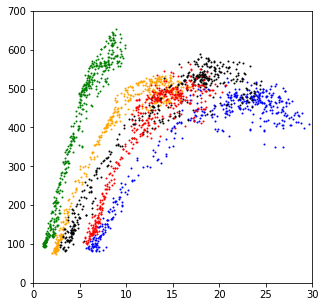

In [30]:
q = pd.read_csv('../data/q_20_aggragated.csv', index_col = 0)
b = pd.read_csv('../data/b_20_aggragated.csv', index_col = 0)  # time occupancy, (density)
v = pd.read_csv('../data/v_20_aggragated.csv', index_col = 0)
id_class = pd.read_csv('../res/%i_id_402_withclass.csv'%randseed)

id_class0 = id_class[id_class.class_i == 0]
q_c0 = q.loc[id_class0.id]
b_c0 = b.loc[id_class0.id]

id_class1 = id_class[id_class.class_i == 1]
q_c1 = q.loc[id_class1.id]
b_c1 = b.loc[id_class1.id]

id_class2 = id_class[id_class.class_i == 2]
q_c2 = q.loc[id_class2.id]
b_c2 = b.loc[id_class2.id]

id_class3 = id_class[id_class.class_i == 3]
q_c3 = q.loc[id_class3.id]
b_c3 = b.loc[id_class3.id]

id_class4 = id_class[id_class.class_i == 4]
q_c4 = q.loc[id_class4.id]
b_c4 = b.loc[id_class4.id]

id_class5 = id_class[id_class.class_i == 5]
q_c5 = q.loc[id_class5.id]
b_c5 = b.loc[id_class5.id]

fig = plt.figure(figsize=[5, 5])
ax2 = fig.add_subplot(111)
ax2.set_xlim([0, 30])
ax2.set_ylim([0, 700])

ax2.scatter(x = b_c0.iloc[:,:432].mean(), y = q_c0.iloc[:,:432].mean(), s=1, c = 'b')
ax2.scatter(x = b_c1.iloc[:,:432].mean(), y = q_c1.iloc[:,:432].mean(), s=1, c = 'g')
ax2.scatter(x = b_c2.iloc[:,:432].mean(), y = q_c2.iloc[:,:432].mean(), s=1, c = 'orange')
ax2.scatter(x = b_c3.iloc[:,:432].mean(), y = q_c3.iloc[:,:432].mean(), s=1, c = 'black')
ax2.scatter(x = b_c4.iloc[:,:432].mean(), y = q_c4.iloc[:,:432].mean(), s=1, c = 'r')
ax2.scatter(x = b_c5.iloc[:,:432].mean(), y = q_c5.iloc[:,:432].mean(), s=1, c = 'grey')

#plt.savefig('./res/img/%i'%randseed)

# CH index (dont know the scale)

In [31]:
cluster_set = b_det['class'].drop_duplicates()

Nu1 = 0  # numerator 1
c = b_det[0].mean()
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    nk = len(cluster)
    ck = cluster[0].mean()
    Nu1 += nk*abs(ck-c)**2

Nu2 = 0  # numerator 2
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    nk = len(cluster)
    ck = cluster[0].mean()
    for i in range(nk):
        Nu2 += (cluster.iloc[i, 0] - ck)**2
        

CH = Nu1*Nu2/((len(cluster_set)-1) * (len(b_det)-len(cluster_set)))
CH

712166.4491921352

## TV

In [32]:
cluster_set = b_det['class'].drop_duplicates()

TV = 0
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    NA = len(cluster)
    TV += NA*cluster[0].std()**2

TV

33230.436033819824

In [33]:
det_partition_results1

,0,det
0,0,HI7000d
1,0,HI7001a
2,0,HI7002a
3,0,HI7039a
4,0,HI7003a
...,...,...
202,3,HI9037g
203,3,HI9097c
204,3,HI9098c
205,3,HI9099c


In [34]:
def get_det_class(det_id, det_partition_results):
    det_class = det_partition_results.loc[det_partition_results['det']==det_id].iloc[0, 0]
    return det_class

In [35]:
org_bound_dets_df1

,from_det,to_det
10,HI7010a,HI7011a
33,HI7049c,HI7029c
40,HI7054d,HI3002d
63,HI8011a,HI8058b
77,HI8023c,HI8025c
92,HI8038d,HI8039d
140,HI9071a,HI9033a
146,HI9038d,HI9039d
163,HI9055a,HI9056a
168,HI8020a,HI9079a


In [36]:
def get_bound_dets_class_df(bound_dets_df, det_partition_results):
    bound_dets_class_df = pd.DataFrame([], columns=['from_det', 'to_det'], index=range(len(bound_dets_df)))
    for i in range(len(bound_dets_df)):
        bound_dets_class_df.iloc[i, 0] = get_det_class(bound_dets_df.iloc[i, 0], det_partition_results)
        bound_dets_class_df.iloc[i, 1] = get_det_class(bound_dets_df.iloc[i, 1], det_partition_results)
    
    return bound_dets_class_df

In [37]:
get_bound_dets_class_df(org_bound_dets_df1, org_det_partition_results1)

,from_det,to_det
0,0,2
1,2,3
2,3,0
3,4,2
4,2,3
5,3,4
6,1,3
7,3,4
8,4,1
9,2,1


In [38]:
get_bound_dets_class_df(bound_dets_df1, det_partition_results1)

,from_det,to_det
0,0,2
1,2,3
2,3,0
3,4,2
4,2,3
5,3,4
6,1,3
7,3,4
8,4,1
9,2,1


# K Means

In [39]:
from sklearn.cluster import KMeans

In [40]:
q_det

HI2063a    450.811559
HI2063c    621.910569
HI2065a    124.134517
HI2065c    722.276246
HI2068a    484.980120
              ...    
HI9099c    532.141112
HI9100a    550.384427
HI9101c    327.532971
HI9102a    504.680056
HI9102c    253.028184
Length: 402, dtype: float64

In [41]:
det_class_km1 = KMeans(n_clusters=4, random_state=randseed).fit(b_det.iloc[:, :1])

In [42]:
b_det_km = b_det.copy()
b_det_km['class'] = det_class_km1.labels_

id_402_km = id_402.copy()
id_402_km['id_node'] = ''
for i in range(len(id_402_km)):
    id_402_km.iloc[i, 4] = b_det_km[b_det_km['det']==id_402_km.iloc[i, 0]].iloc[0, 2]
        
id_402_km['class_i'] = ''
for i in range(len(id_402_km)):
    id_402_km.iloc[i, 5] = b_det_km[b_det_km['det']==id_402_km.iloc[i, 0]].iloc[0, 3]

id_402_km.to_csv('../res/%i_id_402_km_withclass.csv'%randseed)

# bar chart of density

(array([36., 27., 20.,  8.,  1.,  5.,  4.,  3.,  4.,  3.]),
 array([ 0.19619092,  4.93783372,  9.67947651, 14.42111931, 19.16276211,
        23.9044049 , 28.6460477 , 33.3876905 , 38.12933329, 42.87097609,
        47.61261889]),
 <BarContainer object of 10 artists>)

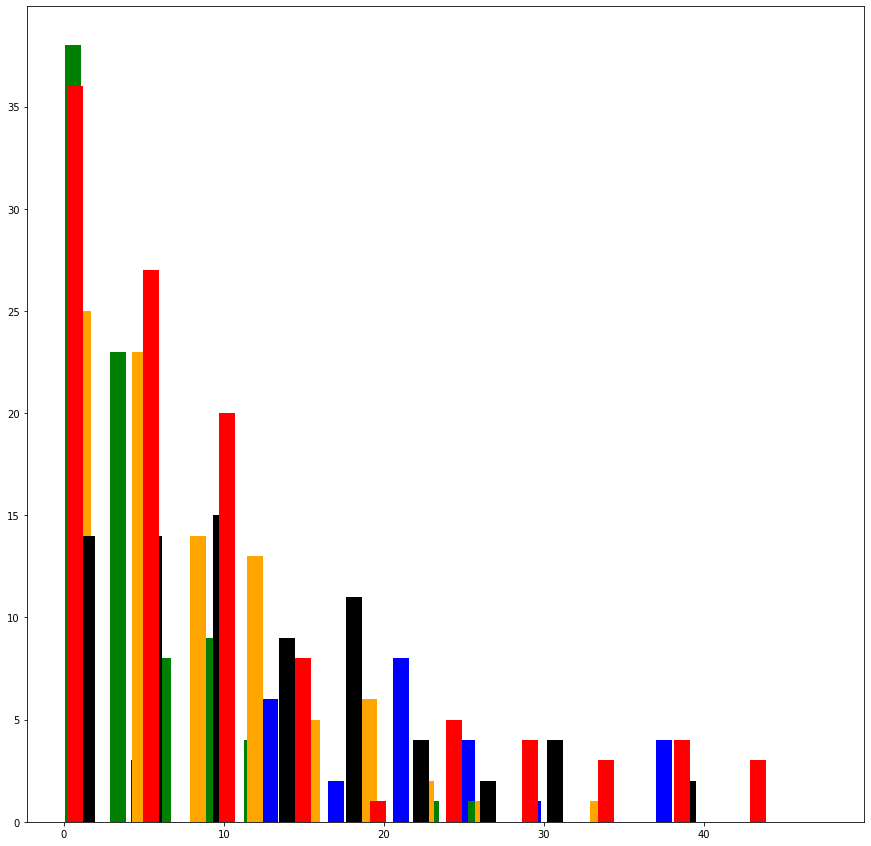

In [44]:
plt.figure(figsize=[15,15])
plt.hist(b_det[b_det['class']==0].iloc[:, 0], color='b', width=1, label='class1')
plt.hist(b_det[b_det['class']==1].iloc[:, 0], color='g', width=1, label='class2')
plt.hist(b_det[b_det['class']==2].iloc[:, 0], color='orange', width=1, label='class3')
plt.hist(b_det[b_det['class']==3].iloc[:, 0], color='black', width=1, label='class4')
plt.hist(b_det[b_det['class']==4].iloc[:, 0], color='r', width=1, label='class5')

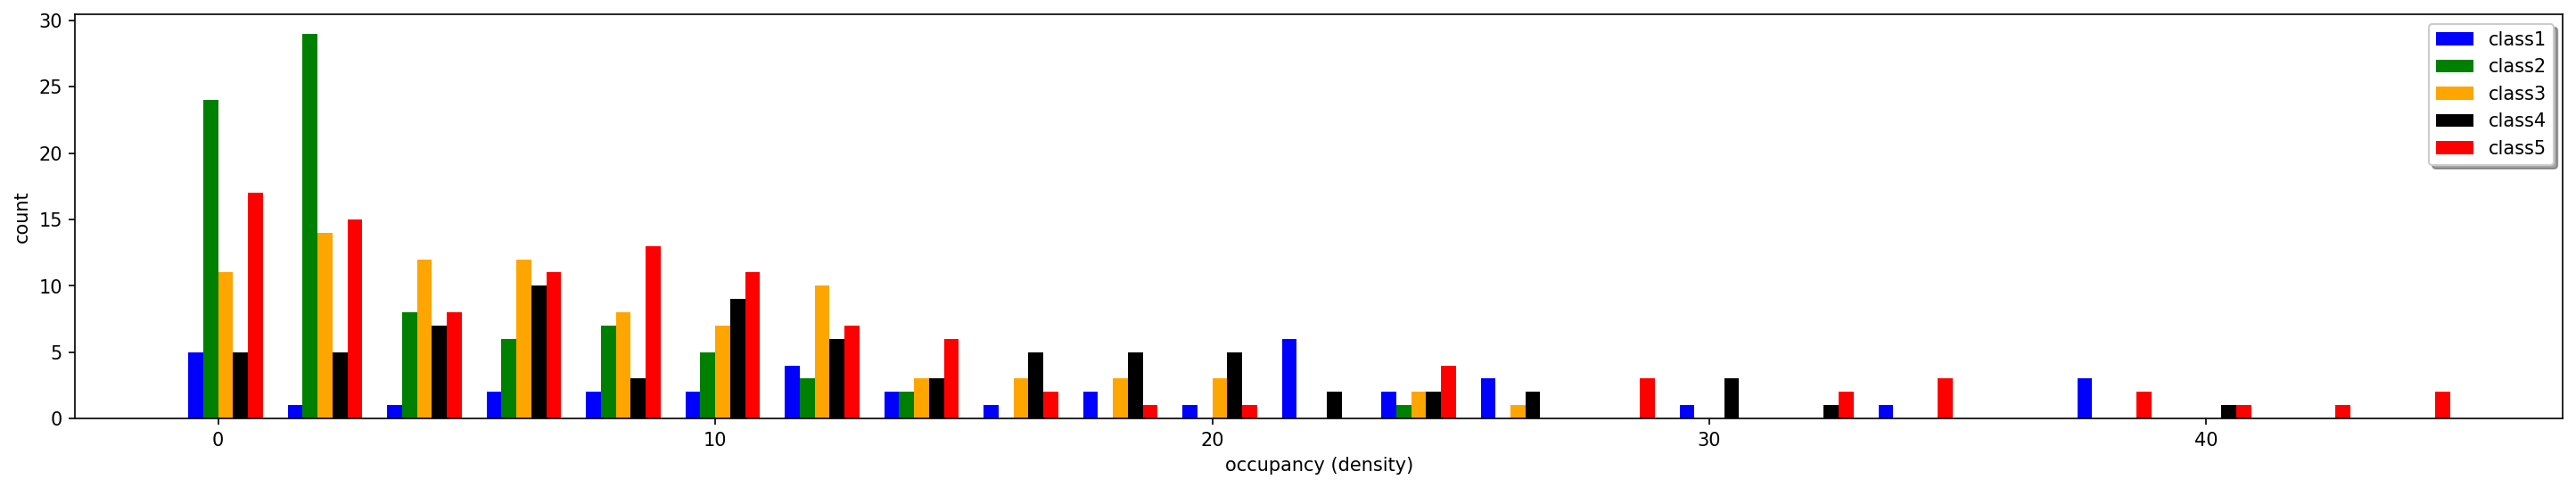

In [51]:
step = 2

dens1 = b_det[b_det['class']==0].iloc[:, 0].sort_values()
n1, bins1 = np.histogram(dens1, bins = list(range(int(min(dens1)), int(max(dens1))+1, step)))

dens2 = b_det[b_det['class']==1].iloc[:, 0].sort_values()
n2, bins2 = np.histogram(dens2, bins = list(range(int(min(dens2)), int(max(dens2))+1, step)))

dens3 = b_det[b_det['class']==2].iloc[:, 0].sort_values()
n3, bins3 = np.histogram(dens3, bins = list(range(int(min(dens3)), int(max(dens3))+1, step)))

dens4 = b_det[b_det['class']==3].iloc[:, 0].sort_values()
n4, bins4 = np.histogram(dens4, bins = list(range(int(min(dens4)), int(max(dens4))+1, step)))

dens5 = b_det[b_det['class']==4].iloc[:, 0].sort_values()
n5, bins5 = np.histogram(dens5, bins = list(range(int(min(dens5)), int(max(dens5))+1, step)))

# plot
w=0.3
plt.figure(figsize=[24, 4], dpi=150)
plt.bar(bins1[:-1]-w/2-w, n1, width=w, label='class1', color='b')
plt.bar(bins2[:-1]-w/2, n2, width=w, label='class2', color='g')
plt.bar(bins3[:-1]+w/2, n3, width=w, label='class3', color='orange')
plt.bar(bins4[:-1]+w/2+w, n4, width=w, label='class4', color='black')
plt.bar(bins5[:-1]+w/2+2*w, n5, width=w, label='class5', color='r')
plt.ylabel('count')
plt.xlabel('occupancy (density)')
plt.legend(loc='upper right', shadow=True)
plt.savefig('../res/bar_chart.png')

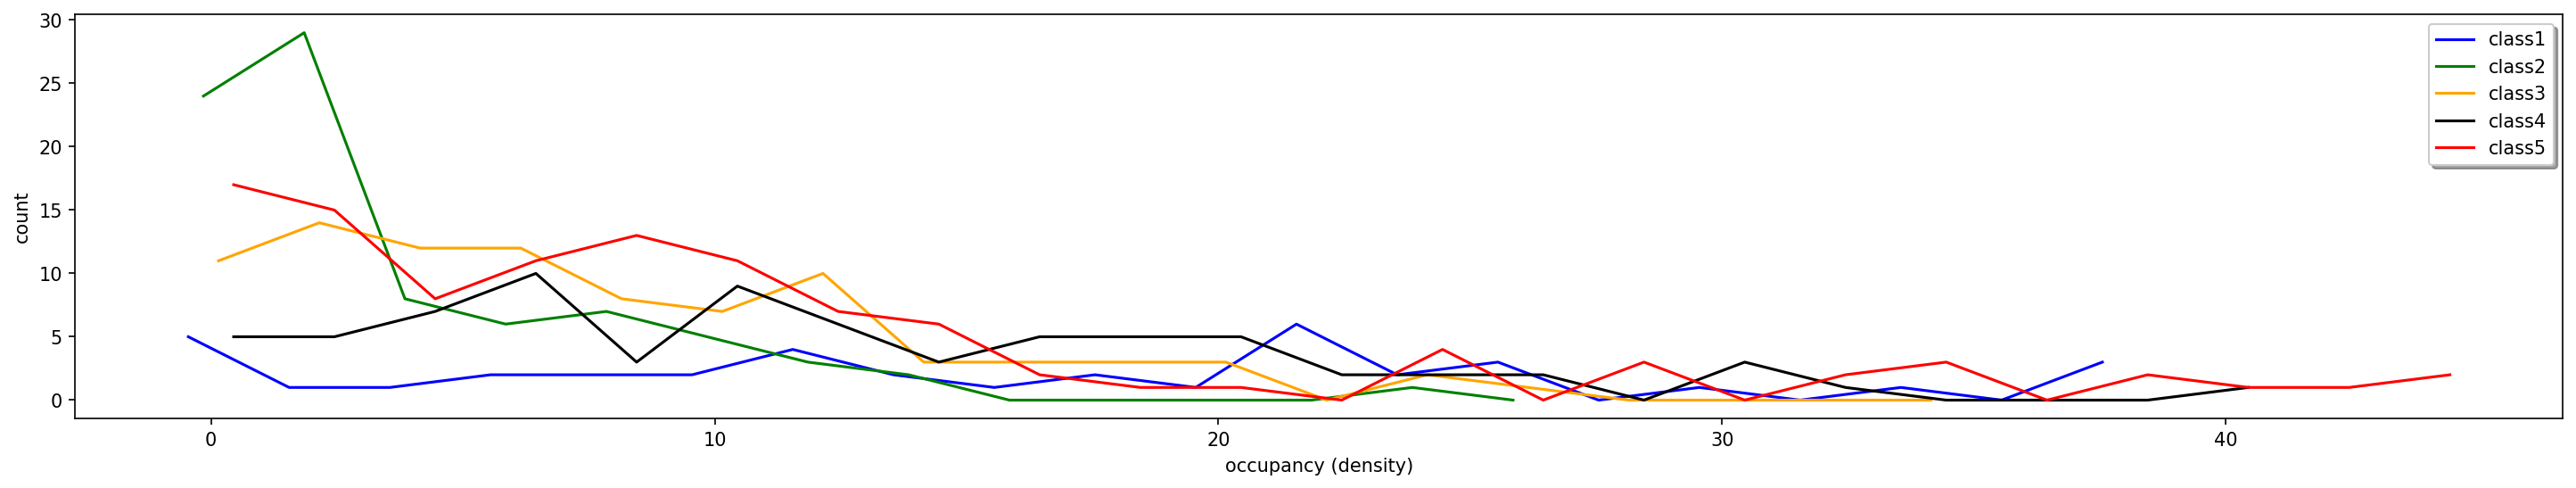

In [53]:
plt.figure(figsize=[24, 4], dpi=150)
plt.plot(bins1[:-1]-w/2-w, n1, label='class1', color='b')
plt.plot(bins2[:-1]-w/2, n2, label='class2', color='g')
plt.plot(bins3[:-1]+w/2, n3, label='class3', color='orange')
plt.plot(bins4[:-1]+w/2+w, n4, label='class4', color='black')
plt.plot(bins5[:-1]+w/2+w, n5, label='class5', color='r')
plt.ylabel('count')
plt.xlabel('occupancy (density)')
plt.legend(loc='upper right', shadow=True)

In [49]:
for i in range(5):
    print('For class %i, var is %.3f, the mean is %.3f'%(i, np.std(b_det[b_det['class']==i].iloc[:, 0])**2, np.mean(b_det[b_det['class']==i].iloc[:, 0])))

For class 0, var is 131.232, the mean is 18.040
For class 1, var is 24.021, the mean is 4.999
For class 2, var is 46.469, the mean is 9.037
For class 3, var is 85.902, the mean is 13.623
For class 4, var is 133.895, the mean is 12.033


In [96]:
import scipy.stats

def js_divergence(set1, set2):
    p = np.array(set1)
    q = np.array(set2)
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)
    # return scipy.stats.entropy(p, q)  # kl divergence

def kl_divergence(set1, set2):
    p = np.array(set1)
    q = np.array(set2)
    M=(p+q)/2
#     return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)
    return scipy.stats.entropy(p, q)  # kl divergence

### after detector selection

In [64]:
selected_dets = pd.read_csv('../network_classification/selected_dets.csv', index_col=0)

In [67]:
b_class = []
for i in range(5):
    b_det_class = b_det.loc[b_det['class']==i]
    b_class.append(b_det_class)

In [69]:
# filt, so that only selected dets remain
class_set = [2, 3, 4]
for i in range(len(class_set)):
    cls_ = class_set[i]
    det_set = selected_dets.loc[selected_dets['class']==cls_, 'det'].values
    b_class[cls_] = b_class[cls_].loc[b_class[cls_]['det'].isin(det_set)]

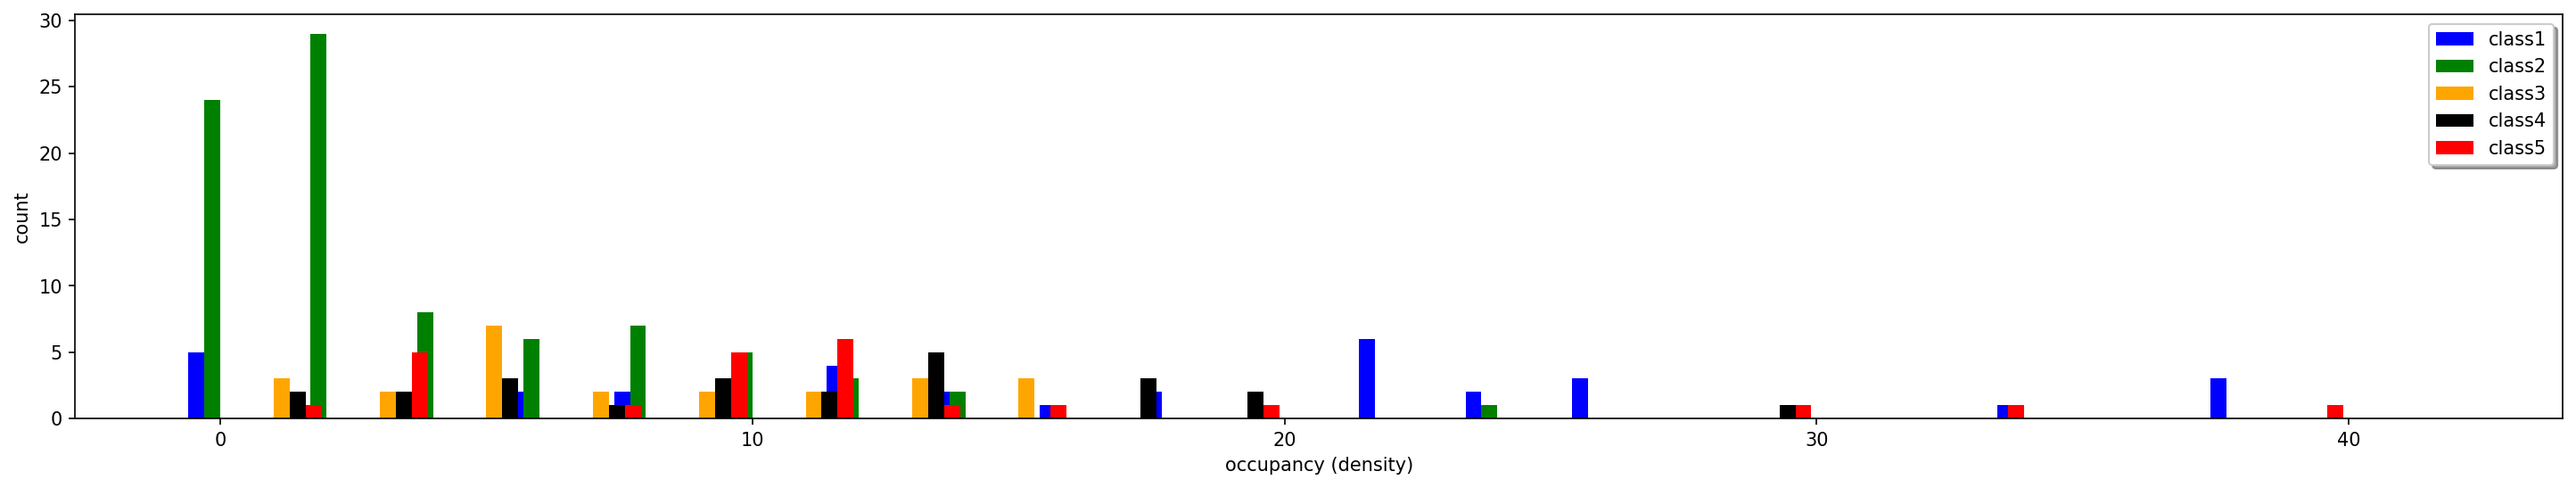

In [77]:
step = 2

dens1 = b_class[0].iloc[:, 0].sort_values()
n1, bins1 = np.histogram(dens1, bins = list(range(int(min(dens1)), int(max(dens1))+1, step)))

dens2 = b_class[1].iloc[:, 0].sort_values()
n2, bins2 = np.histogram(dens2, bins = list(range(int(min(dens2)), int(max(dens2))+1, step)))

dens3 = b_class[2].iloc[:, 0].sort_values()
n3, bins3 = np.histogram(dens3, bins = list(range(int(min(dens3)), int(max(dens3))+1, step)))

dens4 = b_class[3].iloc[:, 0].sort_values()
n4, bins4 = np.histogram(dens4, bins = list(range(int(min(dens4)), int(max(dens4))+1, step)))

dens5 = b_class[4].iloc[:, 0].sort_values()
n5, bins5 = np.histogram(dens5, bins = list(range(int(min(dens5)), int(max(dens5))+1, step)))

# plot
w=0.3
plt.figure(figsize=[24, 4], dpi=150)
plt.bar(bins1[:-1]-w/2-w, n1, width=w, label='class1', color='b')
plt.bar(bins2[:-1]-w/2, n2, width=w, label='class2', color='g')
plt.bar(bins3[:-1]+w/2, n3, width=w, label='class3', color='orange')
plt.bar(bins4[:-1]+w/2+w, n4, width=w, label='class4', color='black')
plt.bar(bins5[:-1]+w/2+2*w, n5, width=w, label='class5', color='r')
plt.ylabel('count')
plt.xlabel('occupancy (density)')
plt.legend(loc='upper right', shadow=True)
plt.savefig('../res/bar_chart.png')

In [95]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--

js_mat = np.zeros((5, 5))
for i in range(2, 5):
    for j in range(2, 5):
        js_mat[i, j] += js_divergence(b_class[i][0], b_class[j][0])

pd.DataFrame(js_mat, columns=['class: 0',1,2,3,4], index=range(5))

,class: 0,1,2,3,4
0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.066703,0.122318
3,0.0,0.0,0.066703,0.000000,0.142026
4,0.0,0.0,0.122318,0.142026,0.000000


In [97]:
kl_mat = np.zeros((5, 5))
for i in range(2, 5):
    for j in range(2, 5):
        kl_mat[i, j] += kl_divergence(b_class[i][0], b_class[j][0])

pd.DataFrame(kl_mat, columns=['class: 0',1,2,3,4], index=range(5))

,class: 0,1,2,3,4
0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.283657,0.505740
3,0.0,0.0,0.275516,0.000000,0.616421
4,0.0,0.0,0.518504,0.645391,0.000000


# n-cut

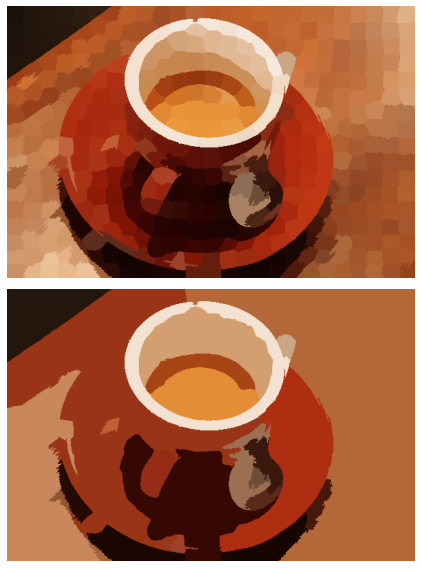

In [48]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400,
                            start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

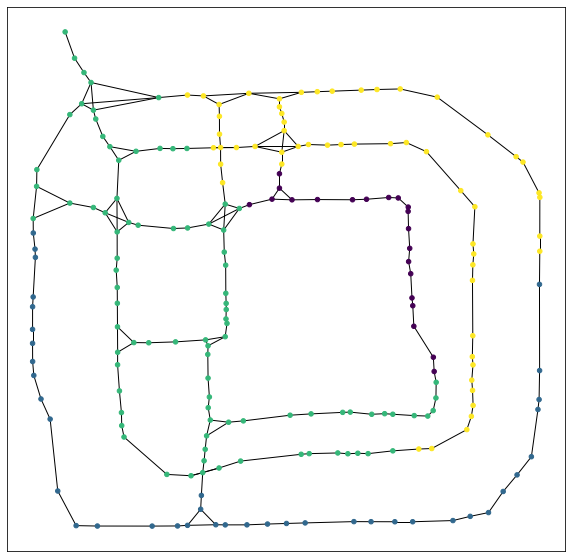

In [49]:
partition = community_louvain.best_partition(G, resolution=11, weight='weight', random_state=randseed)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition.values()), with_labels=False)
#plt.savefig('./res/img/%i_net'%randseed)

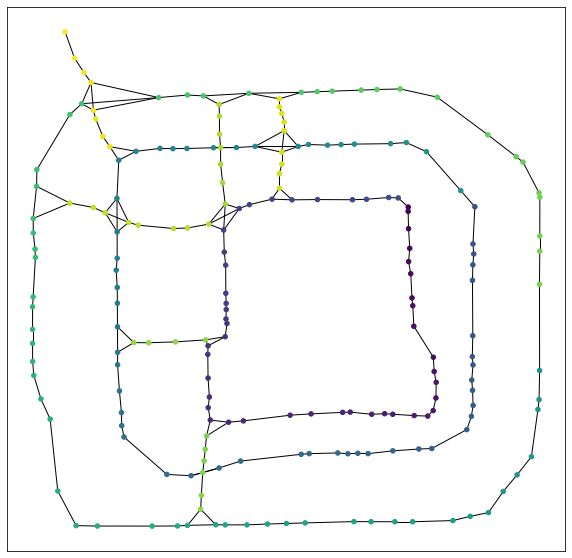

In [50]:
partition = community_louvain.best_partition(G, resolution=0, weight='weight', random_state=randseed)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition.values()), with_labels=False)
#plt.savefig('./res/img/%i_net'%randseed)

# Graph comparison

In [51]:
id_402_km

,id,lat,long,num_road,id_node,class_i
0,HI7000d,116.42769,39.94485,4,2001,1
1,HI7001a,116.42764,39.94330,3,2002,1
2,HI7002a,116.42782,39.93705,2,2003,1
3,HI7039a,116.42832,39.92993,3,2005,1
4,HI7003a,116.42785,39.92513,3,2006,1
...,...,...,...,...,...,...
397,HI9102a,116.29400,39.97990,3,61004,0
398,HI9037a,116.29300,39.98990,3,61005,0
399,HI9097a,116.29000,39.99350,3,61006,0
400,HI9098a,116.28600,39.99870,3,61007,1


In [52]:
partition_results_km = pd.DataFrame([], index=range(len(partition_results)), columns=['class', 'node'])

for i in range(len(partition_results)):
    node = partition_results.iloc[i, 1]
    class_ = id_402_km[id_402_km['id_node']==node].iloc[0, 5]  # 5 means class_i
    partition_results_km.iloc[i, 0] = class_  # class
    partition_results_km.iloc[i, 1] = node

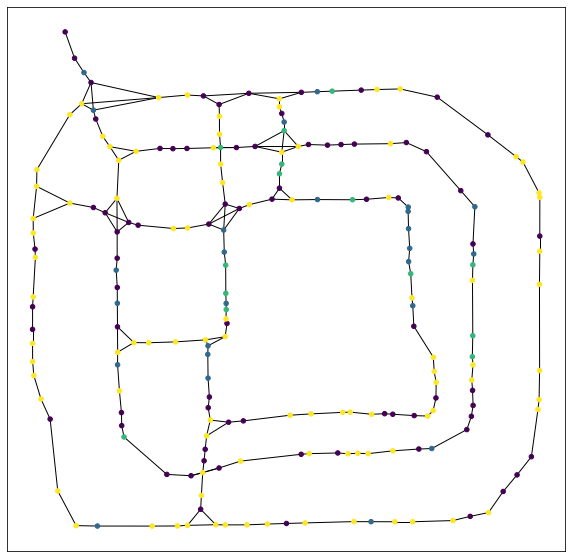

In [53]:
partition = community_louvain.best_partition(G, resolution=15, weight='weight', random_state=randseed)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition_results_km['class'].values), with_labels=False)
#plt.savefig('./res/img/%i_net'%randseed)

In [54]:
seg

,0,1,2,3,4,5,6,7
0,2001,东直门桥北728米（内环）,116.42769,39.94485,4,3,HI7000d,HI7060b
1,2002,东直门桥北539米人行天桥西（外环）,116.42764,39.94330,3,3,HI7001a,HI7000c
2,2003,东直门南机非隔离带内现况视频旁（外环）,116.42782,39.93705,2,3,HI7002a,HI7001c
3,2004,东四十条桥北绿地内中航大厦南20米,116.42760,39.93413,3,3,NaN,NaN
4,2005,东四十条桥南富华大厦附近（外环）,116.42832,39.92993,3,3,HI7039a,HI7002c
...,...,...,...,...,...,...,...,...
227,61005,万泉河桥北第一天桥北,116.29300,39.98990,3,3,HI9097c,HI9037a
228,61006,万泉河桥北第二天桥北,116.29000,39.99350,3,3,HI9098c,HI9097a
229,61007,万泉河桥北无名北立交桥,116.28600,39.99870,3,3,HI9099c,HI9098a
230,61008,无名北立交桥桥北,116.28200,40.00340,3,3,HI9100c,HI9099a
